In [20]:
import matplotlib.pyplot as pl
import pymc3 as pm
import seaborn as sb
import numpy as np
% matplotlib inline
from IPython.display import Image
from scipy import stats

In [2]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00,
                 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47,
                 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19,
                 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

/home/madhatter106/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


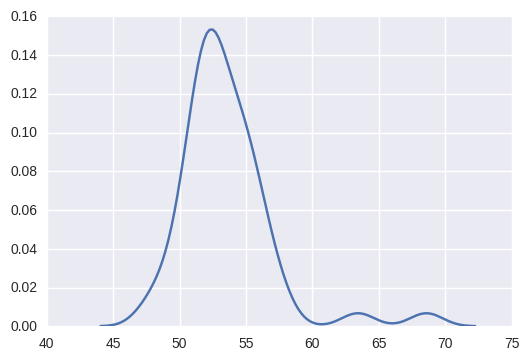

In [3]:
sb.kdeplot(data)

This is sort of gaussian, if we ignore the outliers.
Accordingly, here's one way to model this:

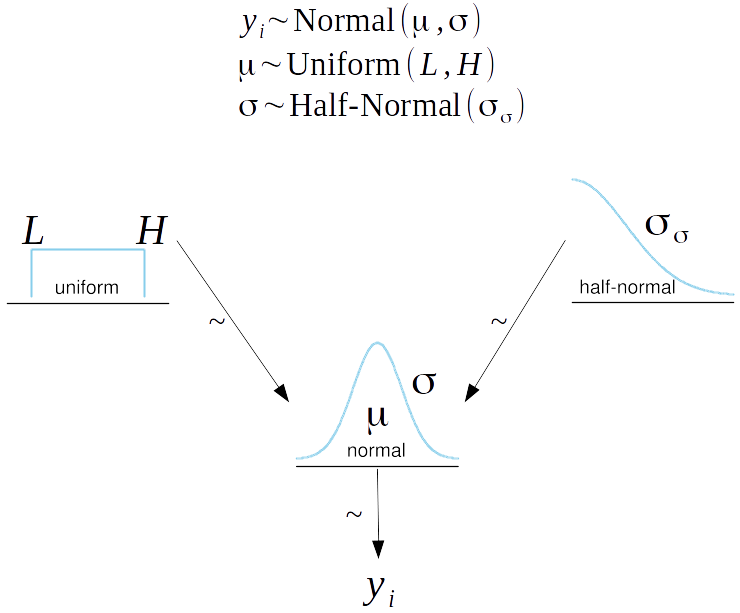

In [6]:
Image('./bay-3-1-gaussMdl.png', width=400, height=400)

This translates in pymc3 to:

In [10]:
uniform_low, uniform_high=np.floor(data.min()/10)*10, np.ceil(data.max()/10)*10

In [13]:
with pm.Model() as gauMdl:
    mu=pm.Uniform('mu',lower=uniform_low, upper=uniform_high)
    sigma = pm.HalfNormal('sigma', 10)
    y = pm.Normal('y',mu=mu, sd=sigma, observed=data)
    trace_gm = pm.sample(1100)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -133.02: 100%|██████████| 200000/200000 [00:17<00:00, 11265.41it/s]
Finished [100%]: Average ELBO = -133.03
100%|██████████| 1100/1100 [00:01<00:00, 608.90it/s]


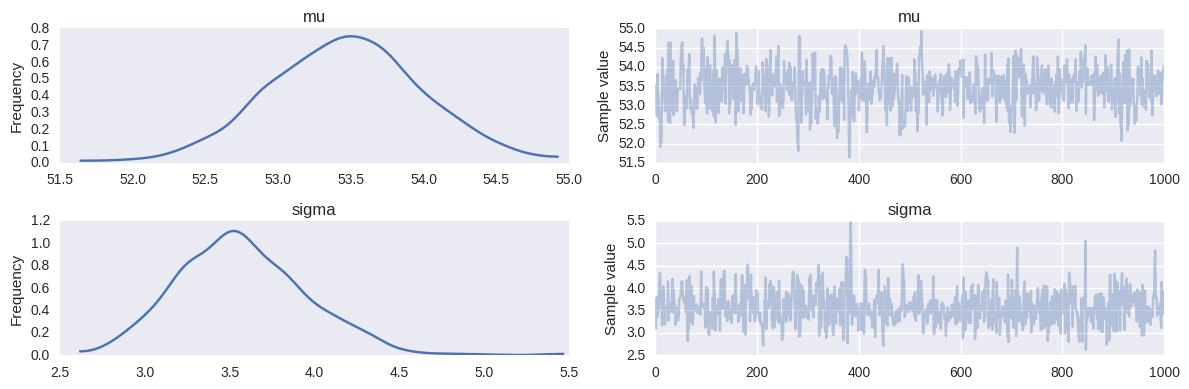

In [15]:
chain_g = trace_gm[100:]
pm.traceplot(chain_g);

In [16]:
pm.df_summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,53.459629,0.526613,0.024367,52.480736,54.537613
sigma,3.572363,0.379872,0.015636,2.918909,4.345076


Now that we have computed the posterior, we can use it to simulate data from it. Then we can check how consistent the simulated data is with the observed data. We generically call these types of comparisons **posterior predictive checks**, because we are using the posterior to make predictions and those predictions to check the model. 

100%|██████████| 100/100 [00:02<00:00, 48.27it/s]
/home/madhatter106/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/madhatter106/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


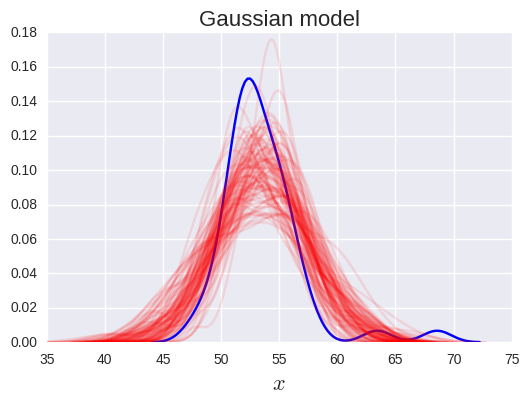

In [18]:
y_pred = pm.sample_ppc(chain_g, 100, gauMdl, size=len(data))
sb.kdeplot(data,c='b');
for i in y_pred['y']:
    sb.kdeplot(i, c='r', alpha=.1)
pl.xlim(35,75)
pl.title('Gaussian model', fontsize=16)
pl.xlabel('$x$', fontsize=16)

The mean of the samples seems to be slightly displaced to the right and that the variance seems to be greater for the samples than for the data. Next is to improve the model...

A note of caution about the t-distribution:
it has a parameter, $\nu$, Kruschke call the normality parameter. If $\nu=1$ we get heavier tails than the Gaussian and the distribution is often called Cauchy or Lorentz, depending on the field.
However, if $\nu\leq1$ then the distribution in question does not have a defined mean. Similarly if $\nu\leq<2$ then the distribution has no defined variance. 
Below is a test of the above; the $\nu$ parameter is parameterized as "df" in scipy's stats methods. 

In [38]:
stdslt2 = np.array([np.std(stats.t(loc=0, scale=1, df=1).rvs(100)) for _ in range(1000)])

In [39]:
mnslt1 = np.array([np.mean(stats.t(loc=0, scale=1, df=0.1).rvs(100)) for _ in range(1000)])

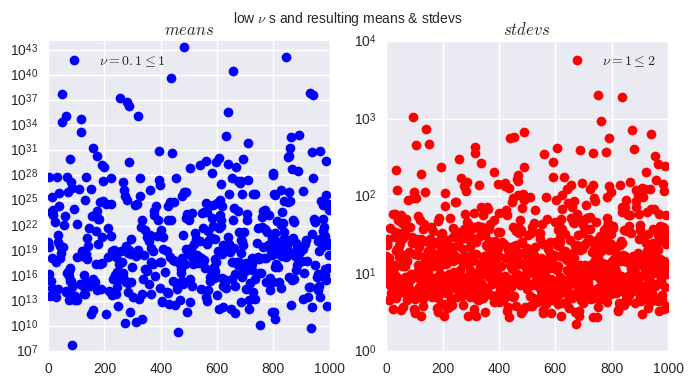

In [47]:
f,axs = pl.subplots(ncols=2,figsize=(8,4))
axs[0].plot(mnslt1,'bo',label=r'$\nu=0.1\leq1$')
axs[0].set_yscale('log')
axs[0].set_title('$means$')
axs[0].legend(loc='best')
axs[1].plot(stdslt2, 'ro', label=r'$\nu=1\leq2$')
axs[1].set_yscale('log')
axs[1].set_title('$stdevs$')
axs[1].legend(loc='best')
f.suptitle(r'low $\nu$ s and resulting means & stdevs');


As can be seen, the means (left) and standard deviations (right) are all over the place even though they come from t-distributions identically parameterized. That's because these moments are, for the $\nu$'s specified in each case, undefined.